In [211]:
import numpy as np
import pandas as pd
import os
import random
import h5py
import torch
import torch.nn as nn
import jax

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

import matplotlib.pyplot as plt

from pytorch_lightning import LightningModule, Trainer
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

from torch.utils.data import DataLoader, TensorDataset

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import corner

garstec_data = 'C:\\Users\\Dell\\Downloads\\Garstec_AS09_chiara.hdf5'

sun_numax = 3090

In [212]:
class GarstecNet(LightningModule):
    def __init__(self, input_dim, output_dim, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr

        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),  # First layer maps input_dim to 256 neurons
            nn.LeakyReLU(),
            nn.Linear(512, 256),  # 2
            nn.LeakyReLU(),
            nn.Linear(256, 128),  # 3
            nn.LeakyReLU(),
            nn.Linear(128, 64),  # 4
            nn.LeakyReLU(),
            nn.Linear(64, 32),  # 5
            nn.LeakyReLU(),
            nn.Linear(32, output_dim)  # Output layer
        )
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        self.log('val_loss', loss, on_epoch=True, prog_bar=False)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=25, verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1
            },
        }
    
ckpt_path = "best_model_v9-1-SS---epoch=8563-val_loss=0.00008340.ckpt" 
input_dim = 7  # Number of input features
output_dim = 5  # Number of output features
model = GarstecNet.load_from_checkpoint(ckpt_path, input_dim=input_dim, output_dim=output_dim)
device = torch.device("cpu")
model.to(device)
model.eval()  

GarstecNet(
  (model): Sequential(
    (0): Linear(in_features=7, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=32, out_features=5, bias=True)
  )
  (criterion): MSELoss()
)

In [213]:
import joblib

scaler_X = joblib.load('scalerXV9.pkl')
scaler_y = joblib.load('scalerYV9.pkl')

In [214]:
import jax.numpy as jnp
import h5py

# List of 10 specific track names
track_names = ['track01336', 'track01239', 'track02584', 'track04056', 'track04248',
               'track05064', 'track05847', 'track06168', 'track07400', 'track09368']

# Initialize empty lists for creating 10 truth arrays
truths = []
for i in range(10):
    truths.append([])

# Open HDF5 file and extract data for each track
with h5py.File(garstec_data, 'r') as hdf:
    for i, track_name in enumerate(track_names):
        specific_track = hdf['grid']['tracks'][track_name]
        
        # Extract parameters
        age = specific_track['age'][:].reshape(-1, 1)
        massini = specific_track['massini'][:].reshape(-1, 1)
        fehini = specific_track['FeHini'][:].reshape(-1, 1)
        alphamlt = specific_track['alphaMLT'][:].reshape(-1, 1)
        yini = specific_track['yini'][:].reshape(-1, 1)
        eta = specific_track['eta'][:].reshape(-1, 1)
        alphafe = specific_track['alphaFe'][:].reshape(-1, 1)
        
        # Select middle age index
        index = len(age) // 2
        
        # Create truth array for each star with only the 7 physical parameters
        # truth[0] = star's age, truth[1] = star's massini, etc.
        star_truth = [
            age[index][0],           
            massini[index][0],      
            alphamlt[index][0],      
            yini[index][0],          
            eta[index][0],
            fehini[index][0],           
            alphafe[index][0]        
        ]
        
        # Store truth array for current star
        truths[i] = jnp.array(star_truth)

# Convert list of arrays to a single jnp array
truths = jnp.array(truths)


In [215]:
state_dict = model.state_dict()
weight = [jnp.asarray(param.numpy()) for name, param in state_dict.items() if "weight" in name]
bias = [jnp.asarray(param.numpy()) for name, param in state_dict.items() if "bias" in name]


def emulate(x):
    mean_x = jnp.array(scaler_X.mean_)
    scale_x = jnp.array(scaler_X.scale_)

    # Add batch dimension to scaling parameters
    if x.ndim > mean_x.ndim:
        # Expand dimensions to allow broadcasting across batch
        mean_x = mean_x[None, :]
        scale_x = scale_x[None, :]  
            
    x = (x - mean_x) / scale_x

    if x.ndim == 1:
        x = x[None, :]  # Convert to shape (1, features) for a single sample

    # Hidden layers
    for i, (w, b) in enumerate(zip(weight[:-1], bias[:-1])):
        if x.shape[1] != w.shape[1]:
            raise ValueError(f"Shape mismatch in layer {i}: x.shape[1] ({x.shape[1]}) != w.shape[1] ({w.shape[1]})")
        #print(f"Layer {i}: x shape: {x.shape}, w.T shape: {w.T.shape}, b shape: {b.shape}")
        x = jax.nn.relu(jnp.dot(x, w.T) + b)

    # Final layer
    if x.shape[1] != weight[-1].shape[1]:  # Corrected check
        raise ValueError(f"Final layer mismatch: x.shape[1] ({x.shape[1]}) != weight[-1].shape[1] ({weight[-1].shape[1]})")
    #print(f"Final layer: x shape: {x.shape}, weight[-1].T shape: {weight[-1].T.shape}, bias[-1] shape: {bias[-1].shape}")
    x = jnp.dot(x, weight[-1].T) + bias[-1]

    # Add batch dimension to y scaling parameters if needed

    mean_y = jnp.array(scaler_y.mean_)
    std_y = jnp.array(scaler_y.scale_)

    if x.ndim > mean_y.ndim:
        mean_y = mean_y[None, :]
        std_y = std_y[None, :]
            
    y = x * std_y + mean_y

    return y

In [216]:
teff_emu = []
lum_emu = []
dnu_emu = []
numax_emu = []
FeH_emu = []

epsilon = 1e-10

for i in range(10):
    # Apply log10 transformation where necessary
    inputs = [truths[i][0], truths[i][1], truths[i][2], truths[i][3], truths[i][4]]
    transformed_inputs = [jnp.log10(jnp.maximum(data, epsilon)) for data in inputs]

    # Combine log-transformed inputs with raw `fehini` and `alphafe`
    x_fake = jnp.hstack(transformed_inputs + [truths[i][5], truths[i][6]])

    # Convert to NumPy array for scaling
    x_fake = jnp.array(x_fake).reshape(1, -1)  # Ensure correct shape

    y_fake = emulate(x_fake)

    # Extract predicted values
    teff_fake = 10**y_fake[:, 0]  # Inverse log10 transformation
    luminosity_fake = 10**y_fake[:, 1]
    dnu_fake = 10**y_fake[:, 2]
    numax_fake = 10**y_fake[:, 3]
    FeH_fake = y_fake[:, 4]  # FeH does not require log transformation

    teff_emu.append(teff_fake)
    lum_emu.append(luminosity_fake)
    dnu_emu.append(dnu_fake)
    numax_emu.append(numax_fake)
    FeH_emu.append(FeH_fake)

In [221]:
# For observational data
obs_err = {
    'teff_err': [70],
    'lum_err': [5],
    'dnu_err': [0.1],
    'feh_err': [0.1],
    'numax_err': [0.5]
}

# Initialize lists to store observations
teff_obs_list = []
lum_obs_list = []
dnu_obs_list = []
feh_obs_list = []
numax_obs_list = []

for i in range(len(track_names)):
    teff_obs = teff_emu[i] + np.random.randn() * obs_err['teff_err'][0]
    lum_obs = lum_emu[i] + np.random.randn() * obs_err['lum_err'][0]
    dnu_obs = dnu_emu[i] + np.random.randn() * obs_err['dnu_err'][0]
    FeH_obs = FeH_emu[i] + np.random.randn() * obs_err['feh_err'][0]
    numax_obs = numax_emu[i] * sun_numax + np.random.randn() * obs_err['numax_err'][0]
    
    # Append to lists
    teff_obs_list.append(teff_obs)
    lum_obs_list.append(lum_obs)
    dnu_obs_list.append(dnu_obs)
    feh_obs_list.append(FeH_obs)
    numax_obs_list.append(numax_obs)

# Convert observations to arrays
teff_obs = jnp.array(teff_obs_list)
lum_obs = jnp.array(lum_obs_list)
dnu_obs = jnp.array(dnu_obs_list)
feh_obs = jnp.array(feh_obs_list)
numax_obs = jnp.array(numax_obs_list)

# Create observation dictionary with all observations
obs = {
    'teff': teff_obs,
    'lum': lum_obs,
    'dnu': dnu_obs,
    'feh': feh_obs,
    'numax': numax_obs,
}

In [218]:
def Bmodel(obs=None):
    with numpyro.plate("star", 10):
        # Define priors
        massini_ = numpyro.deterministic("massini_", 0.8 * numpyro.sample("massini_s", dist.Beta(3, 6)) + 0.7)
        tau_hat = numpyro.deterministic("tau_hat", 4 * numpyro.sample("tau_hat_s", dist.Beta(4, 8)) + 1) 
        
        # Calculate values for joint prior
        tau_ms = (2500) * (massini_**-3.15)
        ages_ = numpyro.deterministic("ages_", tau_hat * tau_ms)
        
        # Rest of priors
        alphamlt_ = numpyro.deterministic("alphamlt_", 0.8 * numpyro.sample("alphamlt_s", dist.Beta(5, 5)) + 1.5)
        yini_ = numpyro.deterministic("yini_", 0.13 * numpyro.sample("yini_s", dist.Beta(2, 7)) + 0.248)
        eta_ = numpyro.deterministic("eta_", 0.3 * numpyro.sample("eta_s", dist.Beta(2, 7)))
        alphafe_ = numpyro.deterministic("alphafe_", 0.4 * numpyro.sample("alphafe_s", dist.Beta(5, 5)) - 0.0)
        fehini_ = numpyro.deterministic("fehini_", 2.2 * numpyro.sample("fehini_s", dist.Beta(2, 2)) - 2) 
        
    # Prepare input features for PyTorch model
    epsilon = 1e-10
    log_vars_inputs = [ages_, massini_, alphamlt_, eta_, yini_] 
    log_transformed_inputs = [jnp.log10(jnp.maximum(var, epsilon)) for var in log_vars_inputs]
        
    # Stack features
    x = jnp.stack([*log_transformed_inputs, fehini_, alphafe_], axis=1)
        
    # Emulate using PyTorch model
    y = emulate(x)
        
    # Extract predictions
    teff = numpyro.deterministic("teff", jnp.power(10.0, y[..., 0])) 
    lum = numpyro.deterministic("lum", jnp.power(10.0, y[..., 1])) 
    dnu = numpyro.deterministic("dnu", jnp.power(10.0, y[..., 2]))
    numax = numpyro.deterministic("numax", jnp.power(10.0, y[..., 3])) * sun_numax
    feh = numpyro.deterministic("feh", y[..., 4])
        
    # Observational likelihoods
    if obs is not None:
        num_obs = len(obs['teff'])
            
        # Sample observations
        numpyro.sample("teff_obs", dist.StudentT(5, teff, obs_err['teff_err'][0]), obs=teff_obs)
        numpyro.sample("lum_obs", dist.StudentT(5, lum, obs_err['lum_err'][0]), obs=lum_obs)
        numpyro.sample("dnu_obs", dist.StudentT(5, dnu, obs_err['dnu_err'][0]), obs=dnu_obs)
        numpyro.sample("feh_obs", dist.StudentT(5, feh, obs_err['feh_err'][0]), obs=feh_obs)
        numpyro.sample("numax_obs", dist.StudentT(5, numax, obs_err['numax_err'][0]), obs=numax_obs)

In [222]:
from jax import random
from numpyro.infer import Predictive
from numpyro.infer.initialization import init_to_median

nuts = NUTS(Bmodel, target_accept_prob=0.8, init_strategy=init_to_median, find_heuristic_step_size=True)
mcmc = MCMC(nuts, num_warmup=2000, num_samples=1000, num_chains=2) # between 1000 and 4000 for testing 
rng = random.PRNGKey(0)
rng, key = random.split(rng)

mcmc.run(key, obs=obs)

C:\Users\Dell\AppData\Local\Temp\ipykernel_27244\1950227769.py:6: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=2000, num_samples=1000, num_chains=2) # between 1000 and 4000 for testing


RuntimeError: Cannot find valid initial parameters. Please check your model again.

In [ ]:
import arviz as az

trace = az.from_numpyro(mcmc)

az.summary(trace)

c:\Users\Dell\miniconda3\Lib\site-packages\numpy\_core\_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\Users\Dell\miniconda3\Lib\site-packages\numpy\_core\_methods.py:194: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\Dell\miniconda3\Lib\site-packages\arviz\stats\stats_utils.py:39: RuntimeWarning: invalid value encountered in subtract
  ary = ary - ary.mean(axis, keepdims=True)
c:\Users\Dell\miniconda3\Lib\site-packages\numpy\_core\_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\Users\Dell\miniconda3\Lib\site-packages\arviz\stats\stats_utils.py:39: RuntimeWarning: invalid value encountered in subtract
  ary = ary - ary.mean(axis, keepdims=True)
c:\Users\Dell\miniconda3\Lib\site-packages\numpy\_core\_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\Users\Dell\miniconda3\Lib\s

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ages_[0],7235.472,3242.945,2289.679,13298.264,67.455,53.397,2665.0,1406.0,1.0
ages_[1],7292.186,3394.819,2029.557,13431.393,72.004,56.377,2500.0,1496.0,1.0
ages_[2],7093.401,3034.535,2329.981,12669.032,66.660,51.393,2369.0,1635.0,1.0
ages_[3],7245.596,3295.313,2122.396,13298.568,63.166,50.460,2971.0,1339.0,1.0
ages_[4],7157.774,3185.161,2644.109,13504.106,72.712,58.175,2270.0,1169.0,1.0
...,...,...,...,...,...,...,...,...,...
yini_s[5],0.225,0.129,0.019,0.461,0.003,0.002,2510.0,1438.0,1.0
yini_s[6],0.220,0.134,0.005,0.462,0.003,0.002,2248.0,977.0,1.0
yini_s[7],0.222,0.131,0.018,0.456,0.003,0.002,1735.0,1175.0,1.0
yini_s[8],0.221,0.130,0.017,0.457,0.003,0.002,2264.0,1602.0,1.0


[ 1.2220112e+04  8.1800002e-01  2.0097656e+00  2.6932129e-01
  4.3505859e-02 -1.0041993e+00  2.0000000e-01]


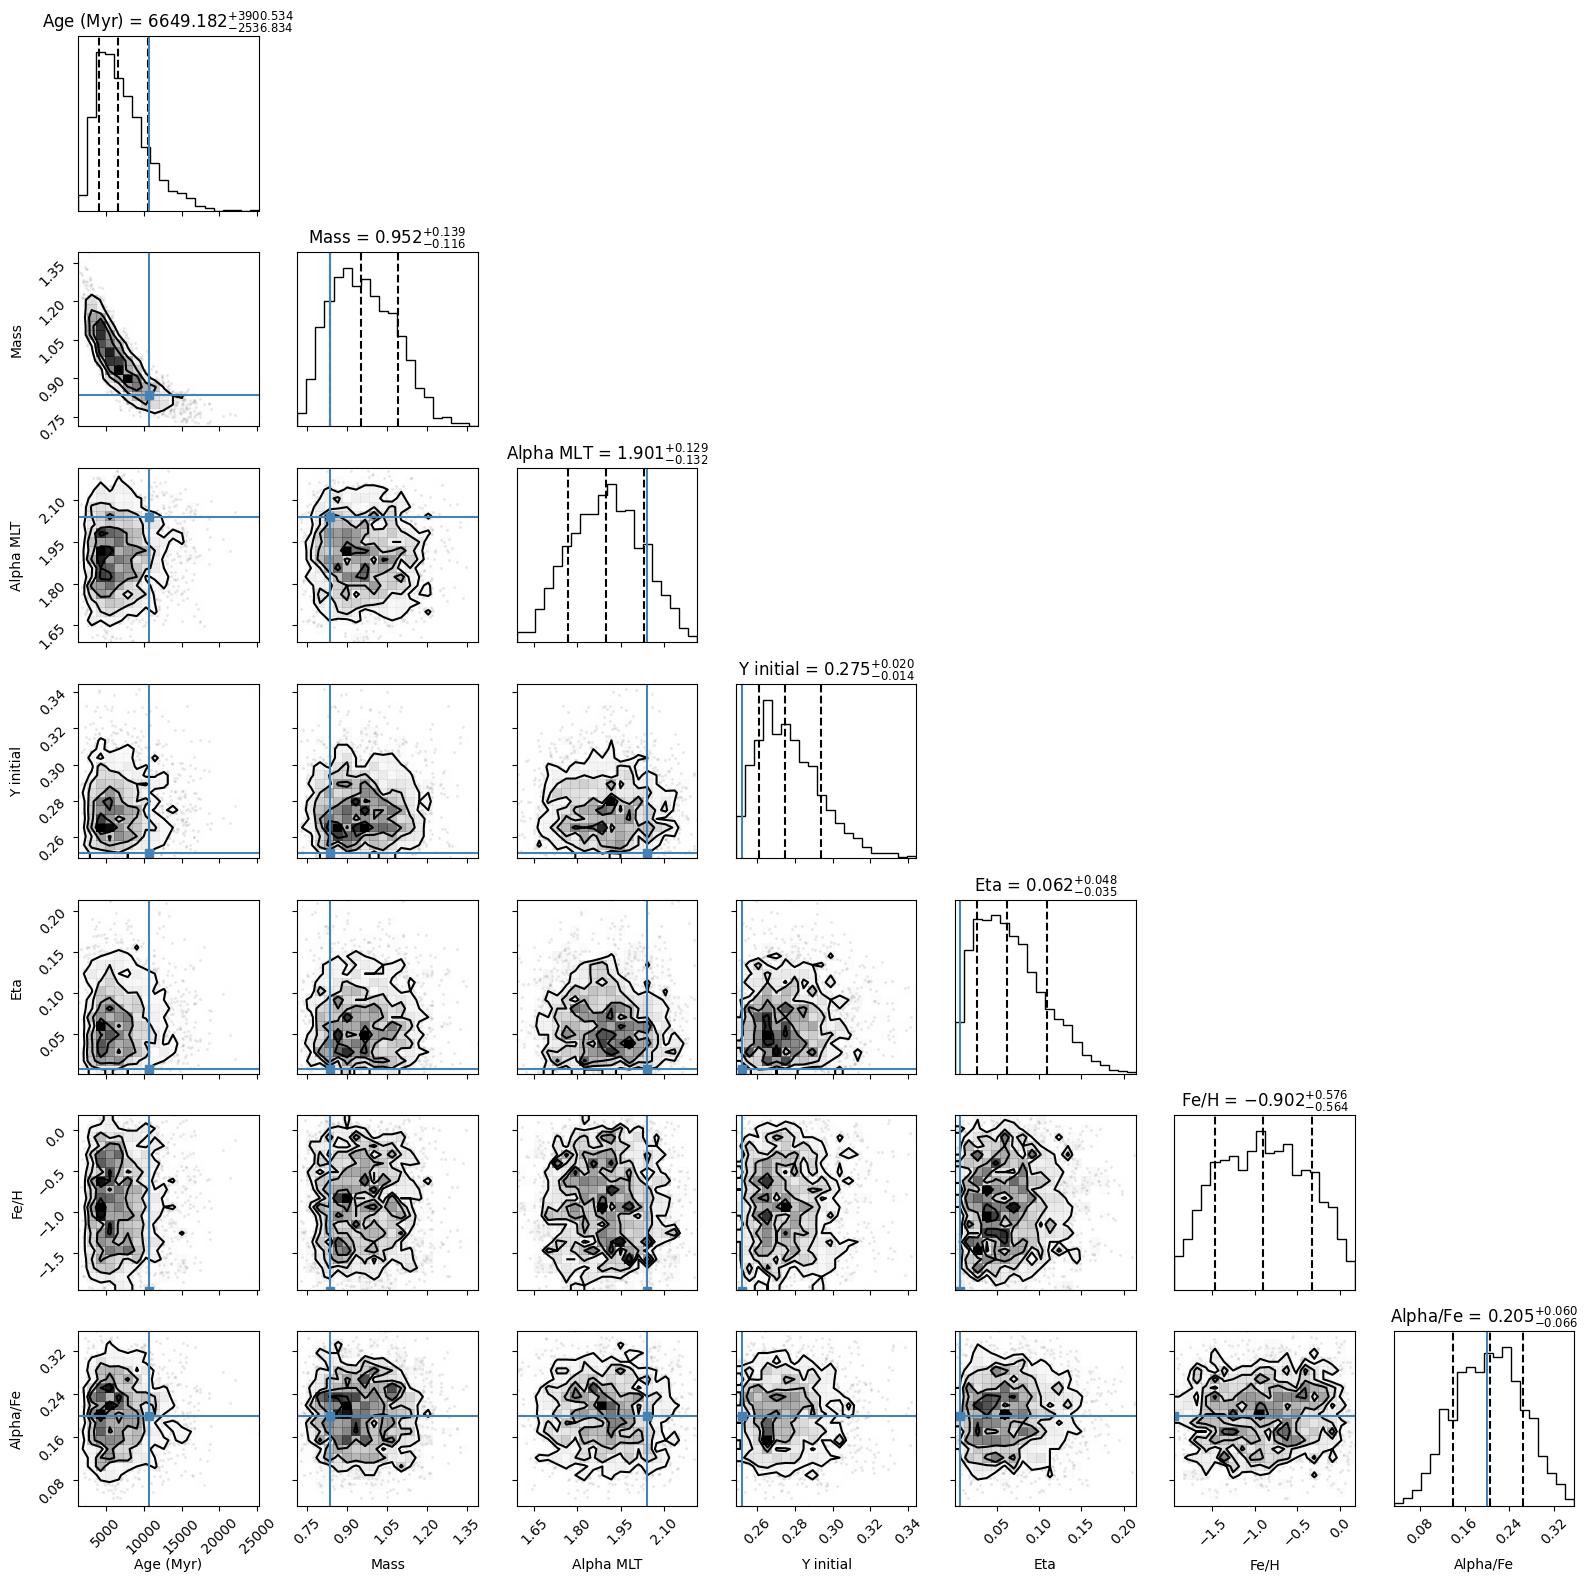

In [ ]:
import corner
import numpy as np
import matplotlib.pyplot as plt

samples = mcmc.get_samples()

# Index

i = 5

params_of_interest = {
    'Age (Myr)': samples['ages_'][..., i],
    'Mass': samples['massini_'][..., i],
    'Alpha MLT': samples['alphamlt_'][..., i],
    'Y initial': samples['yini_'][..., i],
    'Eta': samples['eta_'][..., i],
    'Fe/H': samples['fehini_'][..., i],
    'Alpha/Fe': samples['alphafe_'][..., i]
}

# Convert to a numpy array for corner.py
X = np.column_stack([params_of_interest[key] for key in params_of_interest])
labels = list(params_of_interest.keys())


fig = corner.corner(
    X, 
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],  
    show_titles=True,
    title_kwargs={"fontsize": 12},
    title_fmt='.3f',
    truths = truths[4]
)
print(truths[0])
plt.tight_layout()
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_27244\2674426270.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


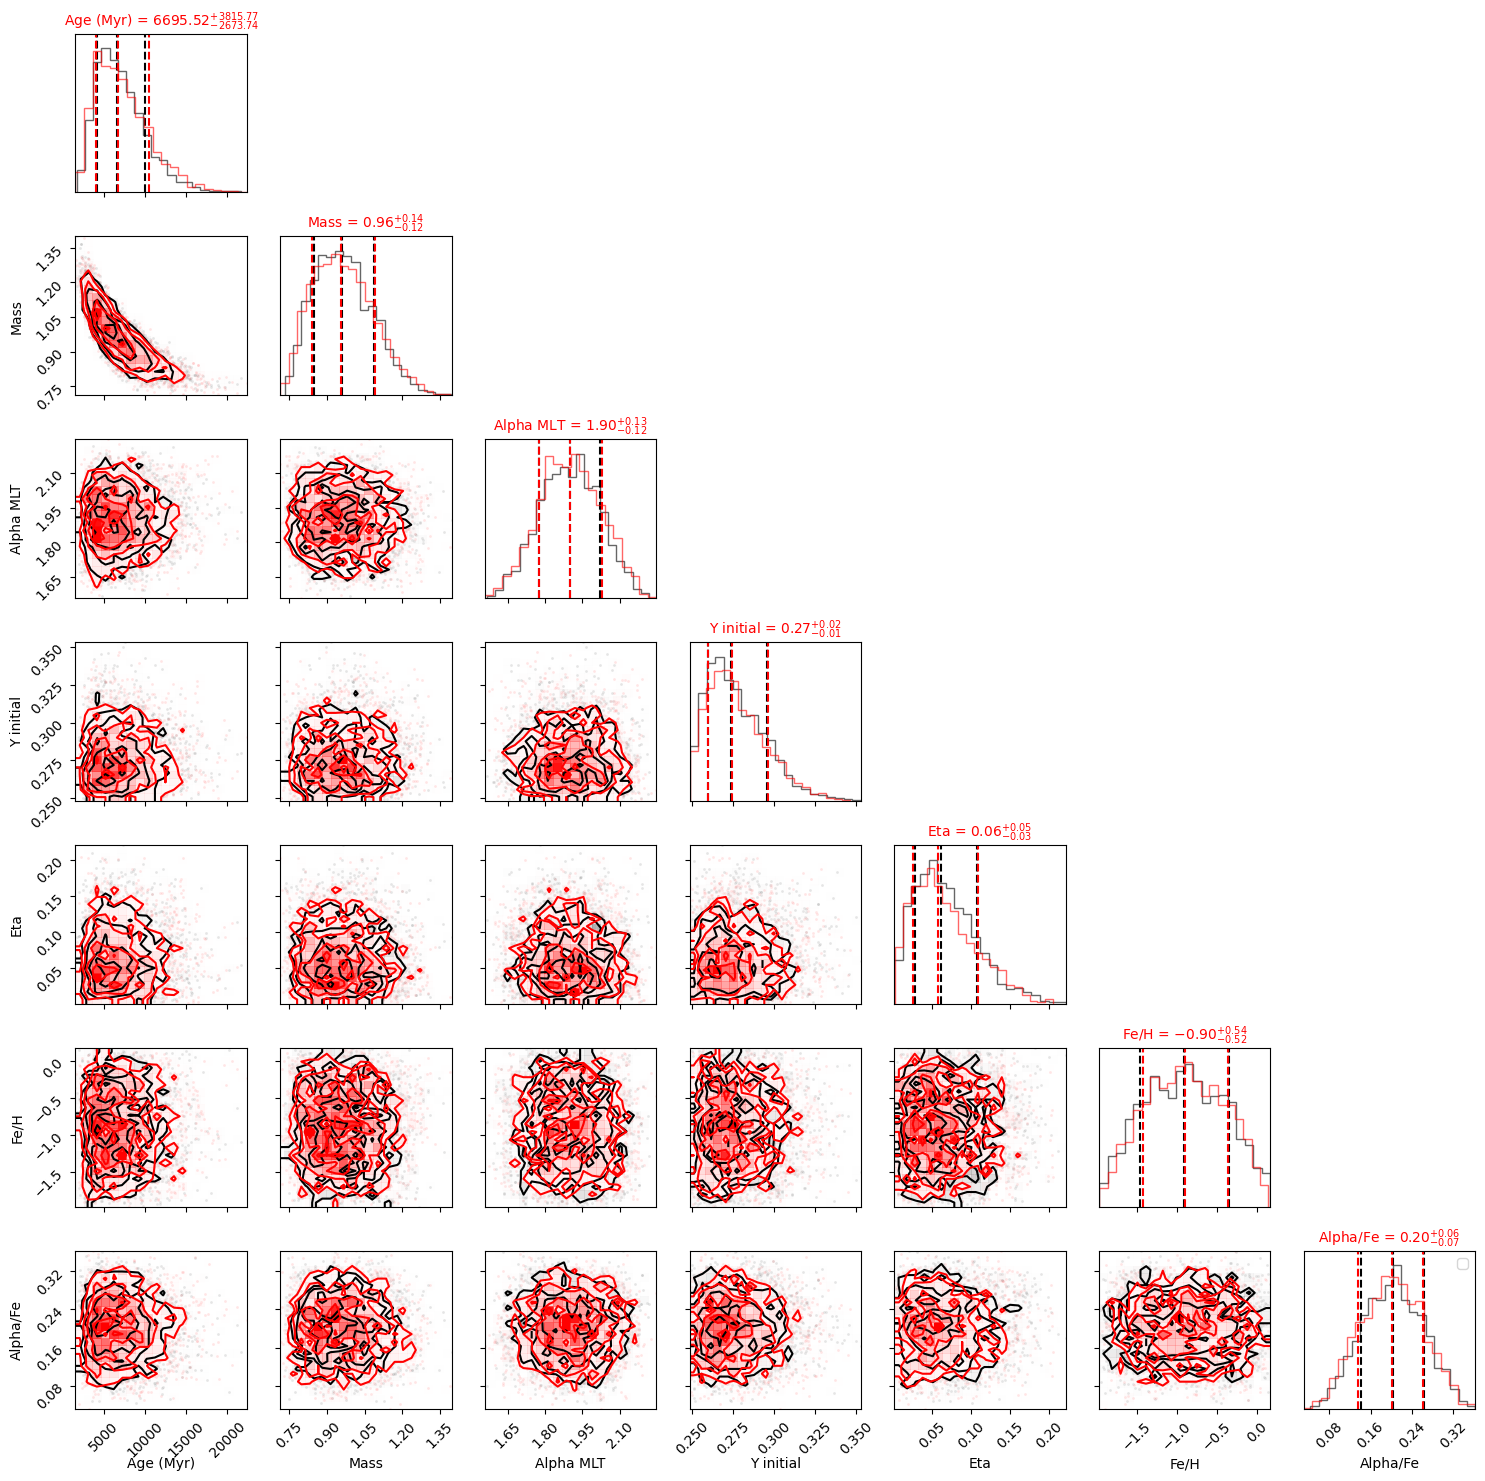

In [ ]:
# Create a figure for the corner plot
fig = plt.figure(figsize=(15, 15))

# Parameters to include
params = ['ages_', 'massini_', 'alphamlt_', 'yini_', 'eta_', 'fehini_', 'alphafe_']
labels = ['Age (Myr)', 'Mass', 'Alpha MLT', 'Y initial', 'Eta', 'Fe/H', 'Alpha/Fe']

# Colors for different stars
colors = ['black', 'red', 'purple']

# Plot each star's corner plot with a different color
for star_idx in range(min(2, len(samples['ages_'][0]))):  # Plot up to 5 stars
    # Extract samples for this star
    X = np.column_stack([samples[param][..., (star_idx+2)] for param in params])
    
    # Add the corner plot for this star
    corner.corner(
        X, 
        labels=labels,
        fig=fig,
        color=colors[star_idx],
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True,
        title_kwargs={"fontsize": 10, "color": colors[star_idx]},
        hist_kwargs={"alpha": 0.6},
    )

plt.tight_layout()
plt.legend()
plt.show()